# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm

# Torch

In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch import optim
from torchvision.datasets import ImageFolder

In [3]:
from torchsummary import summary

# Device

In [4]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

# Data

In [6]:
data_dir = 'Data/'

In [7]:
os.listdir(data_dir)

['Happy', 'Sad']

In [8]:
transform = transforms.Compose([transforms.Resize((60,60)), transforms.ToTensor()])

In [9]:
dataset = ImageFolder(root=data_dir, transform=transform)

In [10]:
train_ratio = 0.8
val_ratio = 1 - train_ratio

In [11]:
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

In [12]:
train_data, val_data = random_split(dataset, [train_size, val_size])

In [13]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

# Visulaization

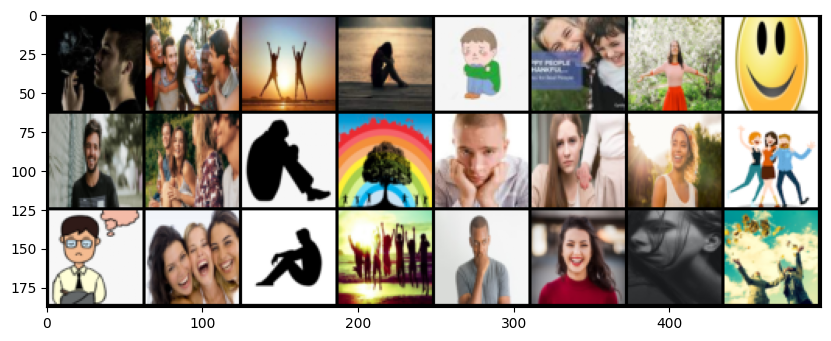

In [14]:
data_iter = iter(train_dataloader)

samples, labels = next(data_iter)
plt.figure(figsize=(10,10))
grid_imgz = torchvision.utils.make_grid(samples[:24])
np_grid_imgz = grid_imgz.numpy()

plt.imshow(np.transpose(np_grid_imgz, (1,2,0)))

# Model Building

In [16]:
class BinaryClassfication(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(128, 2))

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim=1)

In [41]:
model = BinaryClassfication()
model.cuda()
summary(model, (3,60,60))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 29, 29]          --
|    └─Conv2d: 2-1                       [-1, 16, 58, 58]          448
|    └─ReLU: 2-2                         [-1, 16, 58, 58]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 29, 29]          --
├─Sequential: 1-2                        [-1, 32, 13, 13]          --
|    └─Conv2d: 2-4                       [-1, 32, 27, 27]          4,640
|    └─ReLU: 2-5                         [-1, 32, 27, 27]          --
|    └─MaxPool2d: 2-6                    [-1, 32, 13, 13]          --
├─Sequential: 1-3                        [-1, 64, 5, 5]            --
|    └─Conv2d: 2-7                       [-1, 64, 11, 11]          18,496
|    └─ReLU: 2-8                         [-1, 64, 11, 11]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 5, 5]            --
├─Sequential: 1-4                        [-1, 128]                 --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 29, 29]          --
|    └─Conv2d: 2-1                       [-1, 16, 58, 58]          448
|    └─ReLU: 2-2                         [-1, 16, 58, 58]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 29, 29]          --
├─Sequential: 1-2                        [-1, 32, 13, 13]          --
|    └─Conv2d: 2-4                       [-1, 32, 27, 27]          4,640
|    └─ReLU: 2-5                         [-1, 32, 27, 27]          --
|    └─MaxPool2d: 2-6                    [-1, 32, 13, 13]          --
├─Sequential: 1-3                        [-1, 64, 5, 5]            --
|    └─Conv2d: 2-7                       [-1, 64, 11, 11]          18,496
|    └─ReLU: 2-8                         [-1, 64, 11, 11]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 5, 5]            --
├─Sequential: 1-4                        [-1, 128]                 --
|    └─

## Loss and optimizer 

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [21]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data, label in tepoch:
            data,label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() * data.size(0)
            _, pred = torch.max(output.data, 1)

            total += label.size(0)
            correct += (pred==label).sum().item()

        train_acc.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataloader))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataloader)}')


    if epoch%1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        with torch.no_grad():
            for val_data, val_label in val_dataloader:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += val_label.size(0)
                correct += (pred==val_label).sum().item()

            val_acc.append(correct/total)
            val_loss.append(val_running_loss/len(val_dataloader))

            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataloader)}')
            

C:\Users\Mohan krishnan\AppData\Local\Temp\ipykernel_21852\3282276769.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataloader, unit="batch") as tepoch:


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.6602870813397129
Epoch 1 Training Loss = 20.145420287336623
Epoch 1 Validation Accuracy = 0.6981132075471698
Epoch 1 Validation Loss = 17.24666503071785


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6889952153110048
Epoch 2 Training Loss = 18.84707122189658
Epoch 2 Validation Accuracy = 0.6792452830188679
Epoch 2 Validation Loss = 15.9030120074749


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7368421052631579
Epoch 3 Training Loss = 17.335384130477905
Epoch 3 Validation Accuracy = 0.660377358490566
Epoch 3 Validation Loss = 17.180019706487656


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.7751196172248804
Epoch 4 Training Loss = 15.82499246937888
Epoch 4 Validation Accuracy = 0.6415094339622641
Epoch 4 Validation Loss = 17.653992146253586


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7799043062200957
Epoch 5 Training Loss = 15.598113281386238
Epoch 5 Validation Accuracy = 0.7547169811320755
Epoch 5 Validation Loss = 14.5995132625103


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7464114832535885
Epoch 6 Training Loss = 16.814234733581543
Epoch 6 Validation Accuracy = 0.7735849056603774
Epoch 6 Validation Loss = 14.478517293930054


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.7703349282296651
Epoch 7 Training Loss = 15.889570006302424
Epoch 7 Validation Accuracy = 0.7547169811320755
Epoch 7 Validation Loss = 14.242687433958054


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.8181818181818182
Epoch 8 Training Loss = 14.684963728700366
Epoch 8 Validation Accuracy = 0.6792452830188679
Epoch 8 Validation Loss = 15.763508945703506


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8229665071770335
Epoch 9 Training Loss = 14.289839114461627
Epoch 9 Validation Accuracy = 0.7735849056603774
Epoch 9 Validation Loss = 13.795203268527985


  0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.8421052631578947
Epoch 10 Training Loss = 14.00081377370017
Epoch 10 Validation Accuracy = 0.8301886792452831
Epoch 10 Validation Loss = 13.240887179970741


In [22]:
train_loss

[20.145420287336623,
 18.84707122189658,
 17.335384130477905,
 15.82499246937888,
 15.598113281386238,
 16.814234733581543,
 15.889570006302424,
 14.684963728700366,
 14.289839114461627,
 14.00081377370017]

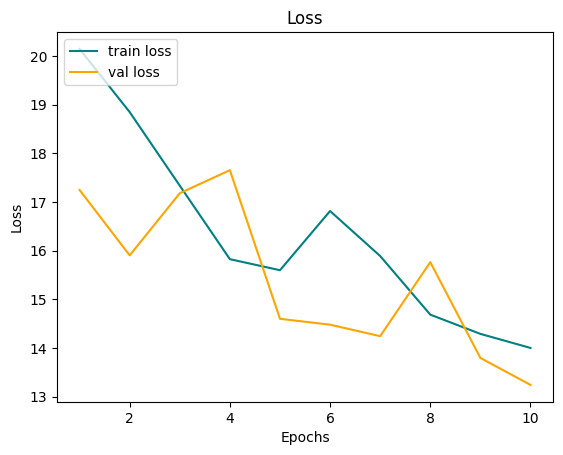

In [44]:
epochs = range(1, len(train_loss)+1)

fig = plt.figure()

plt.plot(epochs, train_loss, color='teal', label='train loss')
plt.plot(epochs, val_loss, color='orange', label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

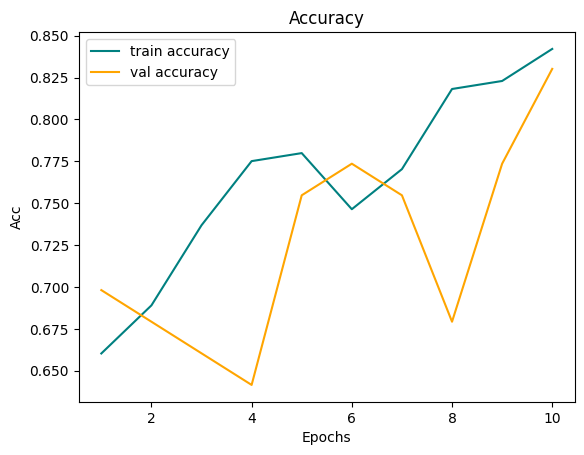

In [42]:
epochs = range(1, len(train_loss)+1)

fig = plt.figure()

plt.plot(epochs, train_acc, color='teal', label='train accuracy')
plt.plot(epochs, val_acc, color='orange', label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='upper left')
plt.show()

# Saving the PyTorch model

In [31]:
PATH = 'Happy or sad.pth'
torch.save(model.state_dict(), PATH)

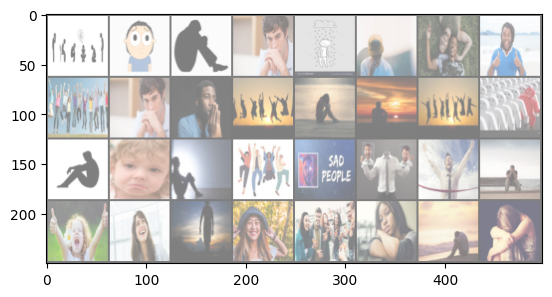

Ground Truth: 11111110011011011110110100100111


In [37]:
def imshow(img):
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

data_iter = iter(val_dataloader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:', ''.join('%1s' % labels[j].numpy() for j in range(32)))


In [38]:
model = BinaryClassfication()
model.to(device)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>